# Model : Convolutional Autoencoder

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from data_prep import DataPrep
from data_plotting import DataPlotting

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



## <ins>Loading and processing data</ins>

In [2]:
file_path = './data/v2_CLD/AE_3C_1D/200716-174206_174209_174205'
data_prep = DataPrep(file_path)
data = data_prep.load_data(2, 'timestamp', True)

Data  1  : 
./data/v2_CLD/AE_3C_1D/200716-174206_174209_174205\c.txt loaded.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 792477 entries, 2020-07-16 08:42:07.312000 to 2020-07-16 09:06:12.722000
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   mag_x        792477 non-null  float64
 1   mag_y        792477 non-null  float64
 2   mag_z        792477 non-null  float64
 3   mag_acc      792477 non-null  int64  
 4   acc_x        792477 non-null  float64
 5   acc_y        792477 non-null  float64
 6   acc_z        792477 non-null  float64
 7   acc_acc      792477 non-null  int64  
 8   gyro_x       792477 non-null  float64
 9   gyro_y       792477 non-null  float64
 10  gyro_z       792477 non-null  float64
 11  gyro_acc     792477 non-null  int64  
 12  pos_lat      792477 non-null  float64
 13  pos_lng      792477 non-null  float64
 14  pos_acc      792477 non-null  float64
 15  activity     792477 non-null

In [3]:
data = data_prep.total_intensity()

In [4]:
data = data_prep.downsampling('250ms')

In [5]:
data[0][['mag_f']]=  data[0][['mag_f']]**(1/10)
data[1][['mag_f']]=  data[1][['mag_f']]**(1/10)
data[2][['mag_f']]=  data[2][['mag_f']]**(1/10)

In [6]:
data = data_prep.normalise(1)

In [7]:
data[0].head()

,mag_x,mag_y,mag_z,mag_f,mag_acc,acc_x,acc_y,acc_z,acc_acc,gyro_x,gyro_y,gyro_z,gyro_acc,pos_lat,pos_lng,pos_acc,mag_f_norm
timestamp,,,,,,,,,,,,,,,,,
2020-07-16 08:42:07.250,-26.852778,31.494445,-29.322222,1.481208,3.0,-1.118641,-3.751132,10.416756,3.0,-0.603842,-0.576057,-0.185889,3.0,35.150231,129.004071,22.279,0.318326
2020-07-16 08:42:07.500,-26.535196,30.893855,-29.544134,1.480142,3.0,-0.219023,-1.886745,9.701967,3.0,1.227637,-0.127939,0.499175,3.0,35.150231,129.004070,22.279,0.316944
2020-07-16 08:42:07.750,-26.716667,24.707639,-35.475000,1.481259,3.0,0.057311,1.379226,9.226048,3.0,0.221575,-0.181960,0.109071,3.0,35.150231,129.004070,22.279,0.318393
2020-07-16 08:42:08.000,-28.806383,23.295745,-34.617731,1.480867,3.0,0.690549,1.134818,9.991301,3.0,0.611258,-0.312470,0.069023,3.0,35.150231,129.004070,22.279,0.317884
2020-07-16 08:42:08.250,-30.427858,20.094286,-35.157143,1.480938,3.0,2.083665,2.844953,8.689644,3.0,0.325324,-0.507127,-0.055470,3.0,35.150231,129.004070,22.279,0.317976


In [8]:
data[1].head()

,mag_x,mag_y,mag_z,mag_f,mag_acc,acc_x,acc_y,acc_z,acc_acc,gyro_x,gyro_y,gyro_z,gyro_acc,pos_lat,pos_lng,pos_acc,mag_f_norm
timestamp,,,,,,,,,,,,,,,,,
2020-07-16 08:42:13.500,-64.873915,53.520244,-18.878774,1.561546,2.0,-2.786658,8.044915,7.462714,3.0,-0.057514,-0.673525,-0.057473,3.0,35.150310,129.003927,9.618000,0.343721
2020-07-16 08:42:13.750,-70.062448,55.364075,-16.743962,1.569780,2.0,-1.410946,5.606661,7.090550,3.0,-0.395289,-0.450018,0.186151,3.0,35.150310,129.003927,9.618000,0.352620
2020-07-16 08:42:14.000,-72.437242,58.415687,-17.969406,1.576423,2.0,-0.925708,5.359957,8.233162,3.0,-0.157223,0.022841,0.035097,3.0,35.150310,129.003927,9.618000,0.359798
2020-07-16 08:42:14.250,-71.200442,59.205820,-18.999702,1.576016,2.0,-0.822154,5.291569,8.305169,3.0,0.055568,0.084165,0.042251,3.0,35.150310,129.003927,9.618000,0.359358
2020-07-16 08:42:14.500,-71.326553,59.226970,-19.194660,1.576259,2.0,-0.954372,4.854390,8.180255,3.0,-0.100496,-0.153049,0.006132,3.0,35.150311,129.003919,10.036232,0.359621


In [9]:
data[2].head()

,mag_x,mag_y,mag_z,mag_f,mag_acc,acc_x,acc_y,acc_z,acc_acc,gyro_x,gyro_y,gyro_z,gyro_acc,pos_lat,pos_lng,pos_acc,mag_f_norm
timestamp,,,,,,,,,,,,,,,,,
2020-07-16 08:42:05.750,-24.905435,38.434783,-43.786957,1.514259,3.0,2.525375,0.196650,9.596832,3.0,0.424172,-0.656573,-0.024142,3.0,35.150136,128.99892,1700.0,0.443115
2020-07-16 08:42:06.000,-16.702143,33.557144,-47.869286,1.509067,3.0,1.266097,1.576992,9.034093,3.0,0.715074,1.366255,-0.290208,3.0,35.150136,128.99892,1700.0,0.435919
2020-07-16 08:42:06.250,-3.913971,27.594853,-49.277206,1.497408,3.0,-1.446846,1.859828,6.703879,3.0,-1.149600,-0.190878,0.145362,3.0,35.150136,128.99892,1700.0,0.419764
2020-07-16 08:42:06.500,2.356250,54.971876,-54.037501,1.545644,3.0,-0.157559,-3.091373,11.873772,3.0,-0.849607,0.286165,1.074935,3.0,35.150136,128.99892,1700.0,0.486605
2020-07-16 08:42:06.750,10.020134,50.638256,-53.584565,1.539897,3.0,-0.618869,-0.729468,9.612053,3.0,0.796668,-0.641497,-0.617553,3.0,35.150136,128.99892,1700.0,0.478641


#### Visualizing total intensity

In [10]:
data_plotting = DataPlotting()

dir_name = 'AE_3C_1D'
file_name = '200716-174206_174209_174205'

Data 1 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 

Data 2 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 

Data 3 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 



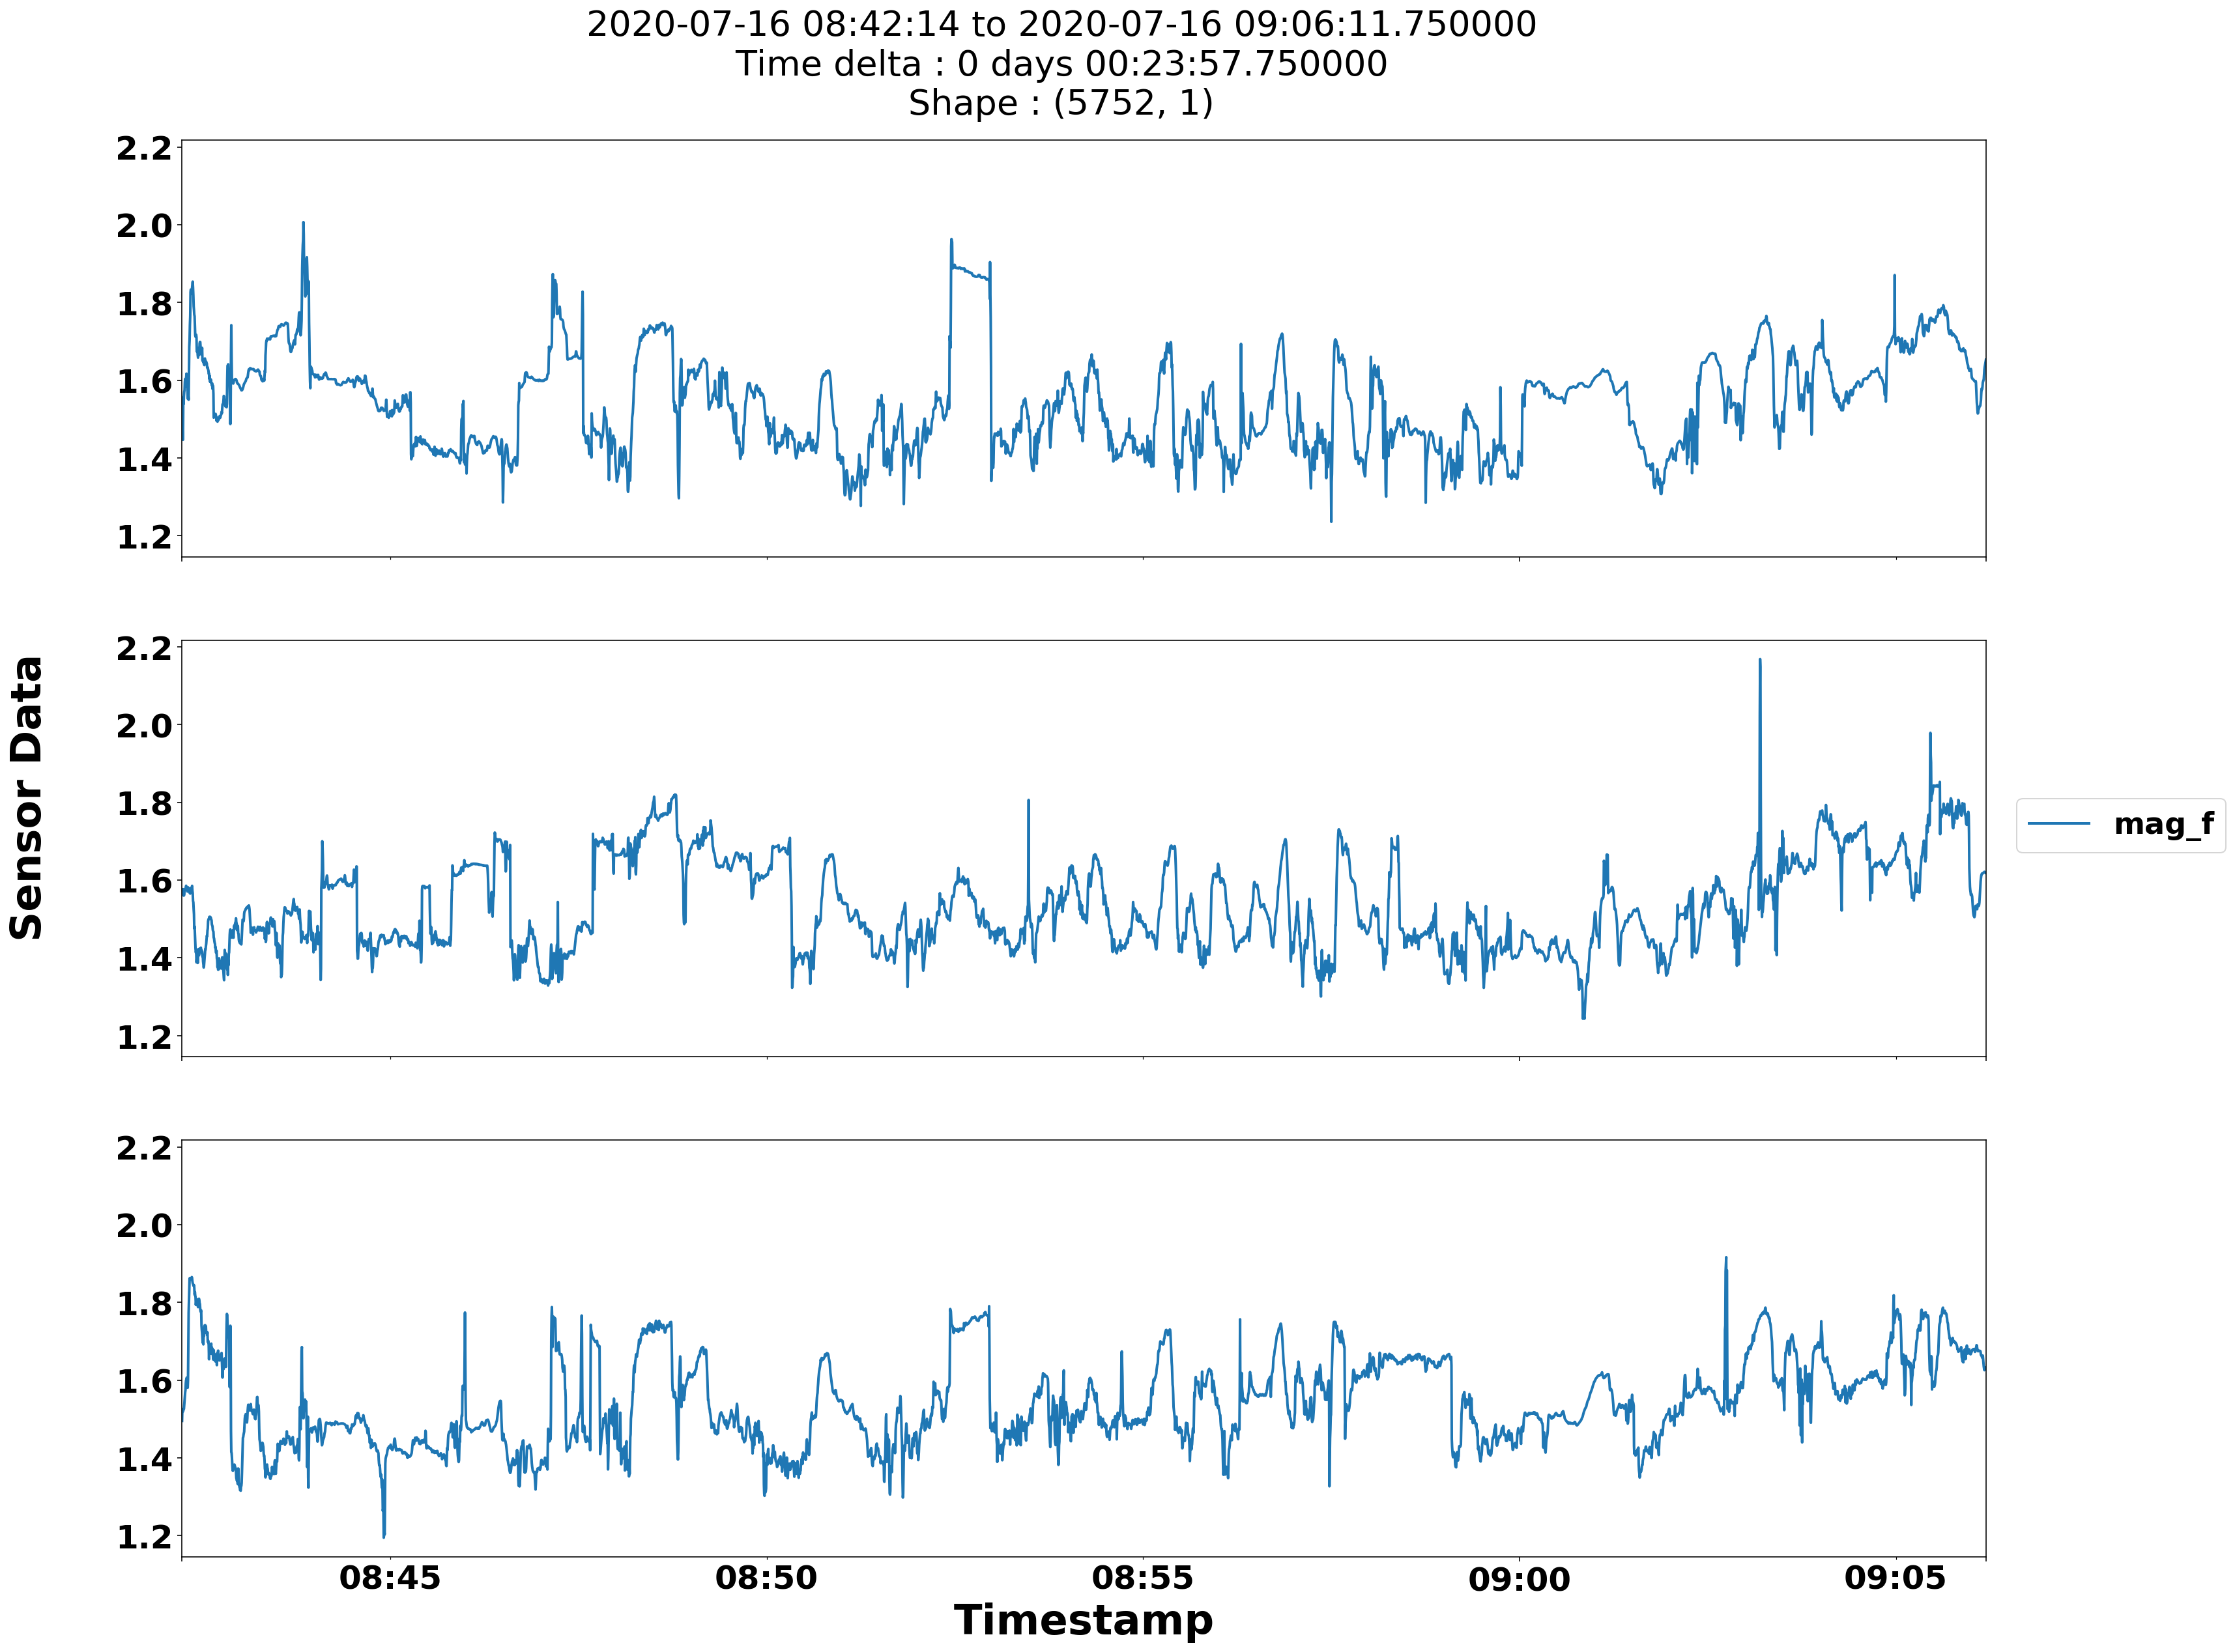

In [11]:
data_display = ['mag_f']
time_from = "2020-07-16 08:42:14"
time_to = "2020-07-16 09:06:11"
data_plotting.plot_data_comp(data, (time_from, time_to), data_display,
                             'Timestamp', 'Sensor Data', (23, 0.894), 27, (25, 20),
                             dir_name, '(pp)' + file_name + '_st_1ti(ds)', False)

Data 1 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 

Data 2 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 

Data 3 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 



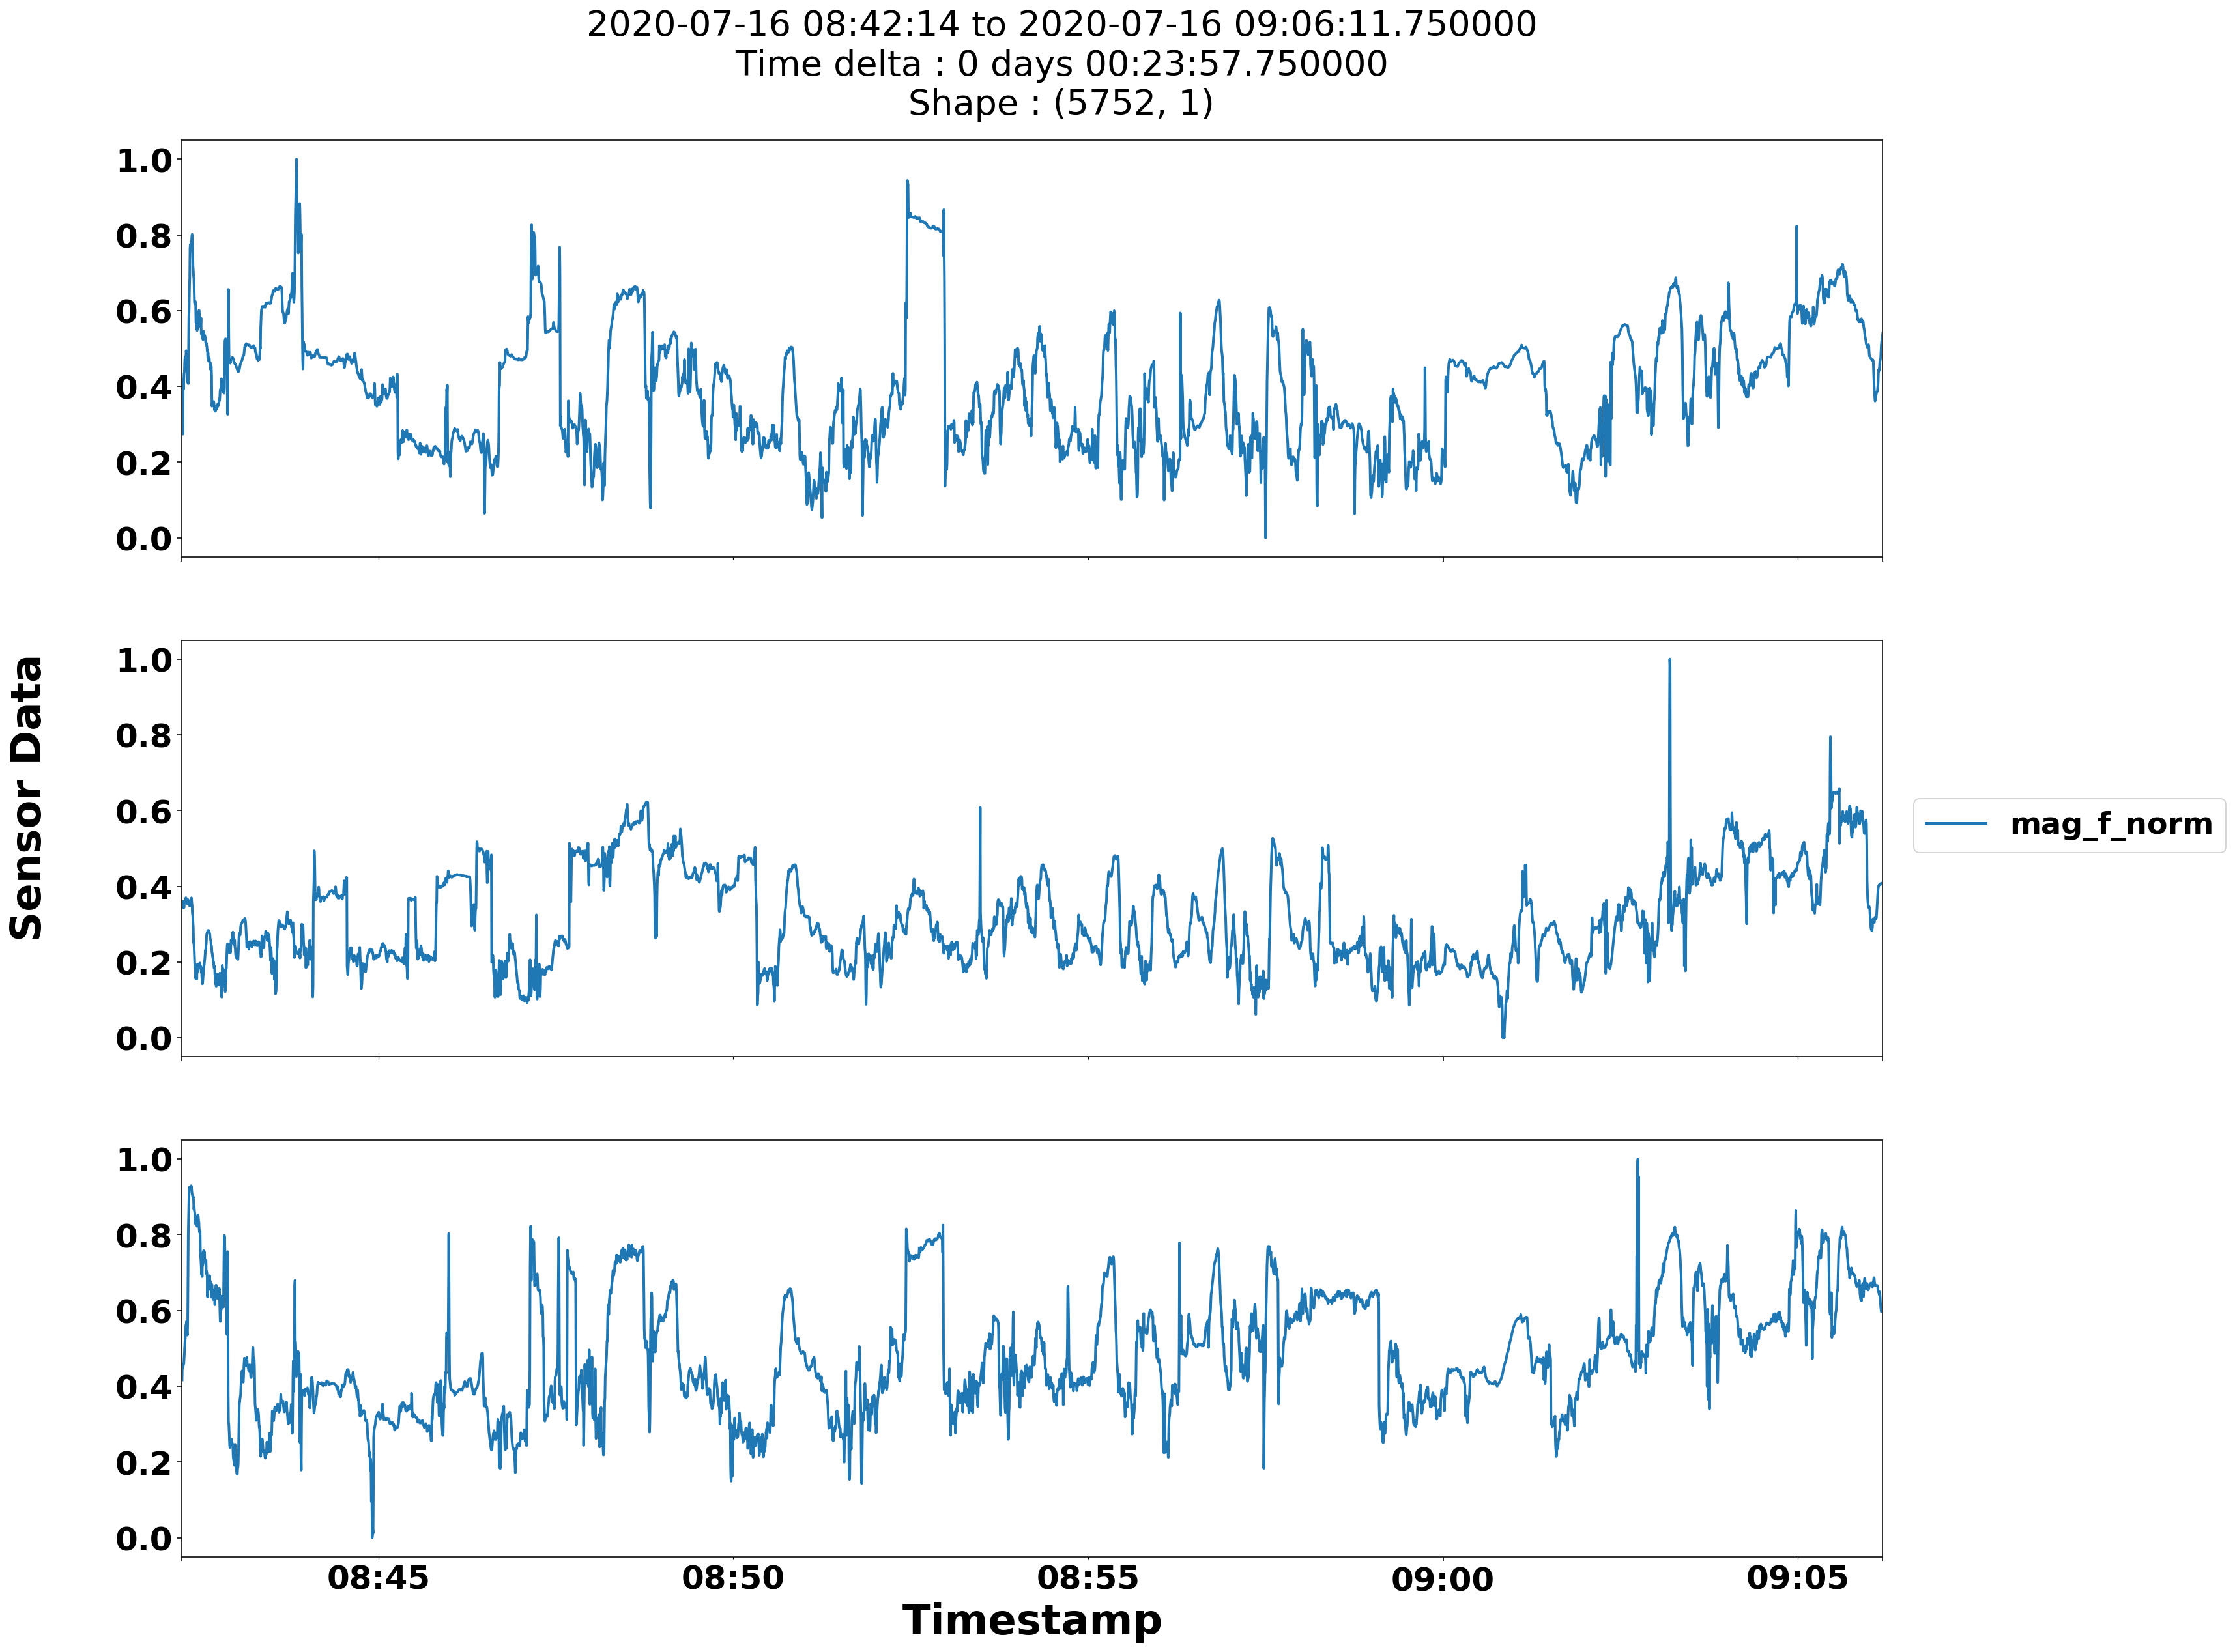

In [12]:
data_display = ['mag_f_norm']
time_from = "2020-07-16 08:42:14"
time_to = "2020-07-16 09:06:11"
data_plotting.plot_data_comp(data, (time_from, time_to), data_display, 
                             'Timestamp', 'Sensor Data', (23, 0.85), 27, (25, 20),
                             dir_name, '(pp)' + file_name + '_st_1tin(ds)', False)

Data 1 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:55:00.750000
Time delta :
 0 days 00:05:00.750000
Shape :
 (1204, 1) 

Data 2 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:55:00.750000
Time delta :
 0 days 00:05:00.750000
Shape :
 (1204, 1) 

Data 3 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:55:00.750000
Time delta :
 0 days 00:05:00.750000
Shape :
 (1204, 1) 



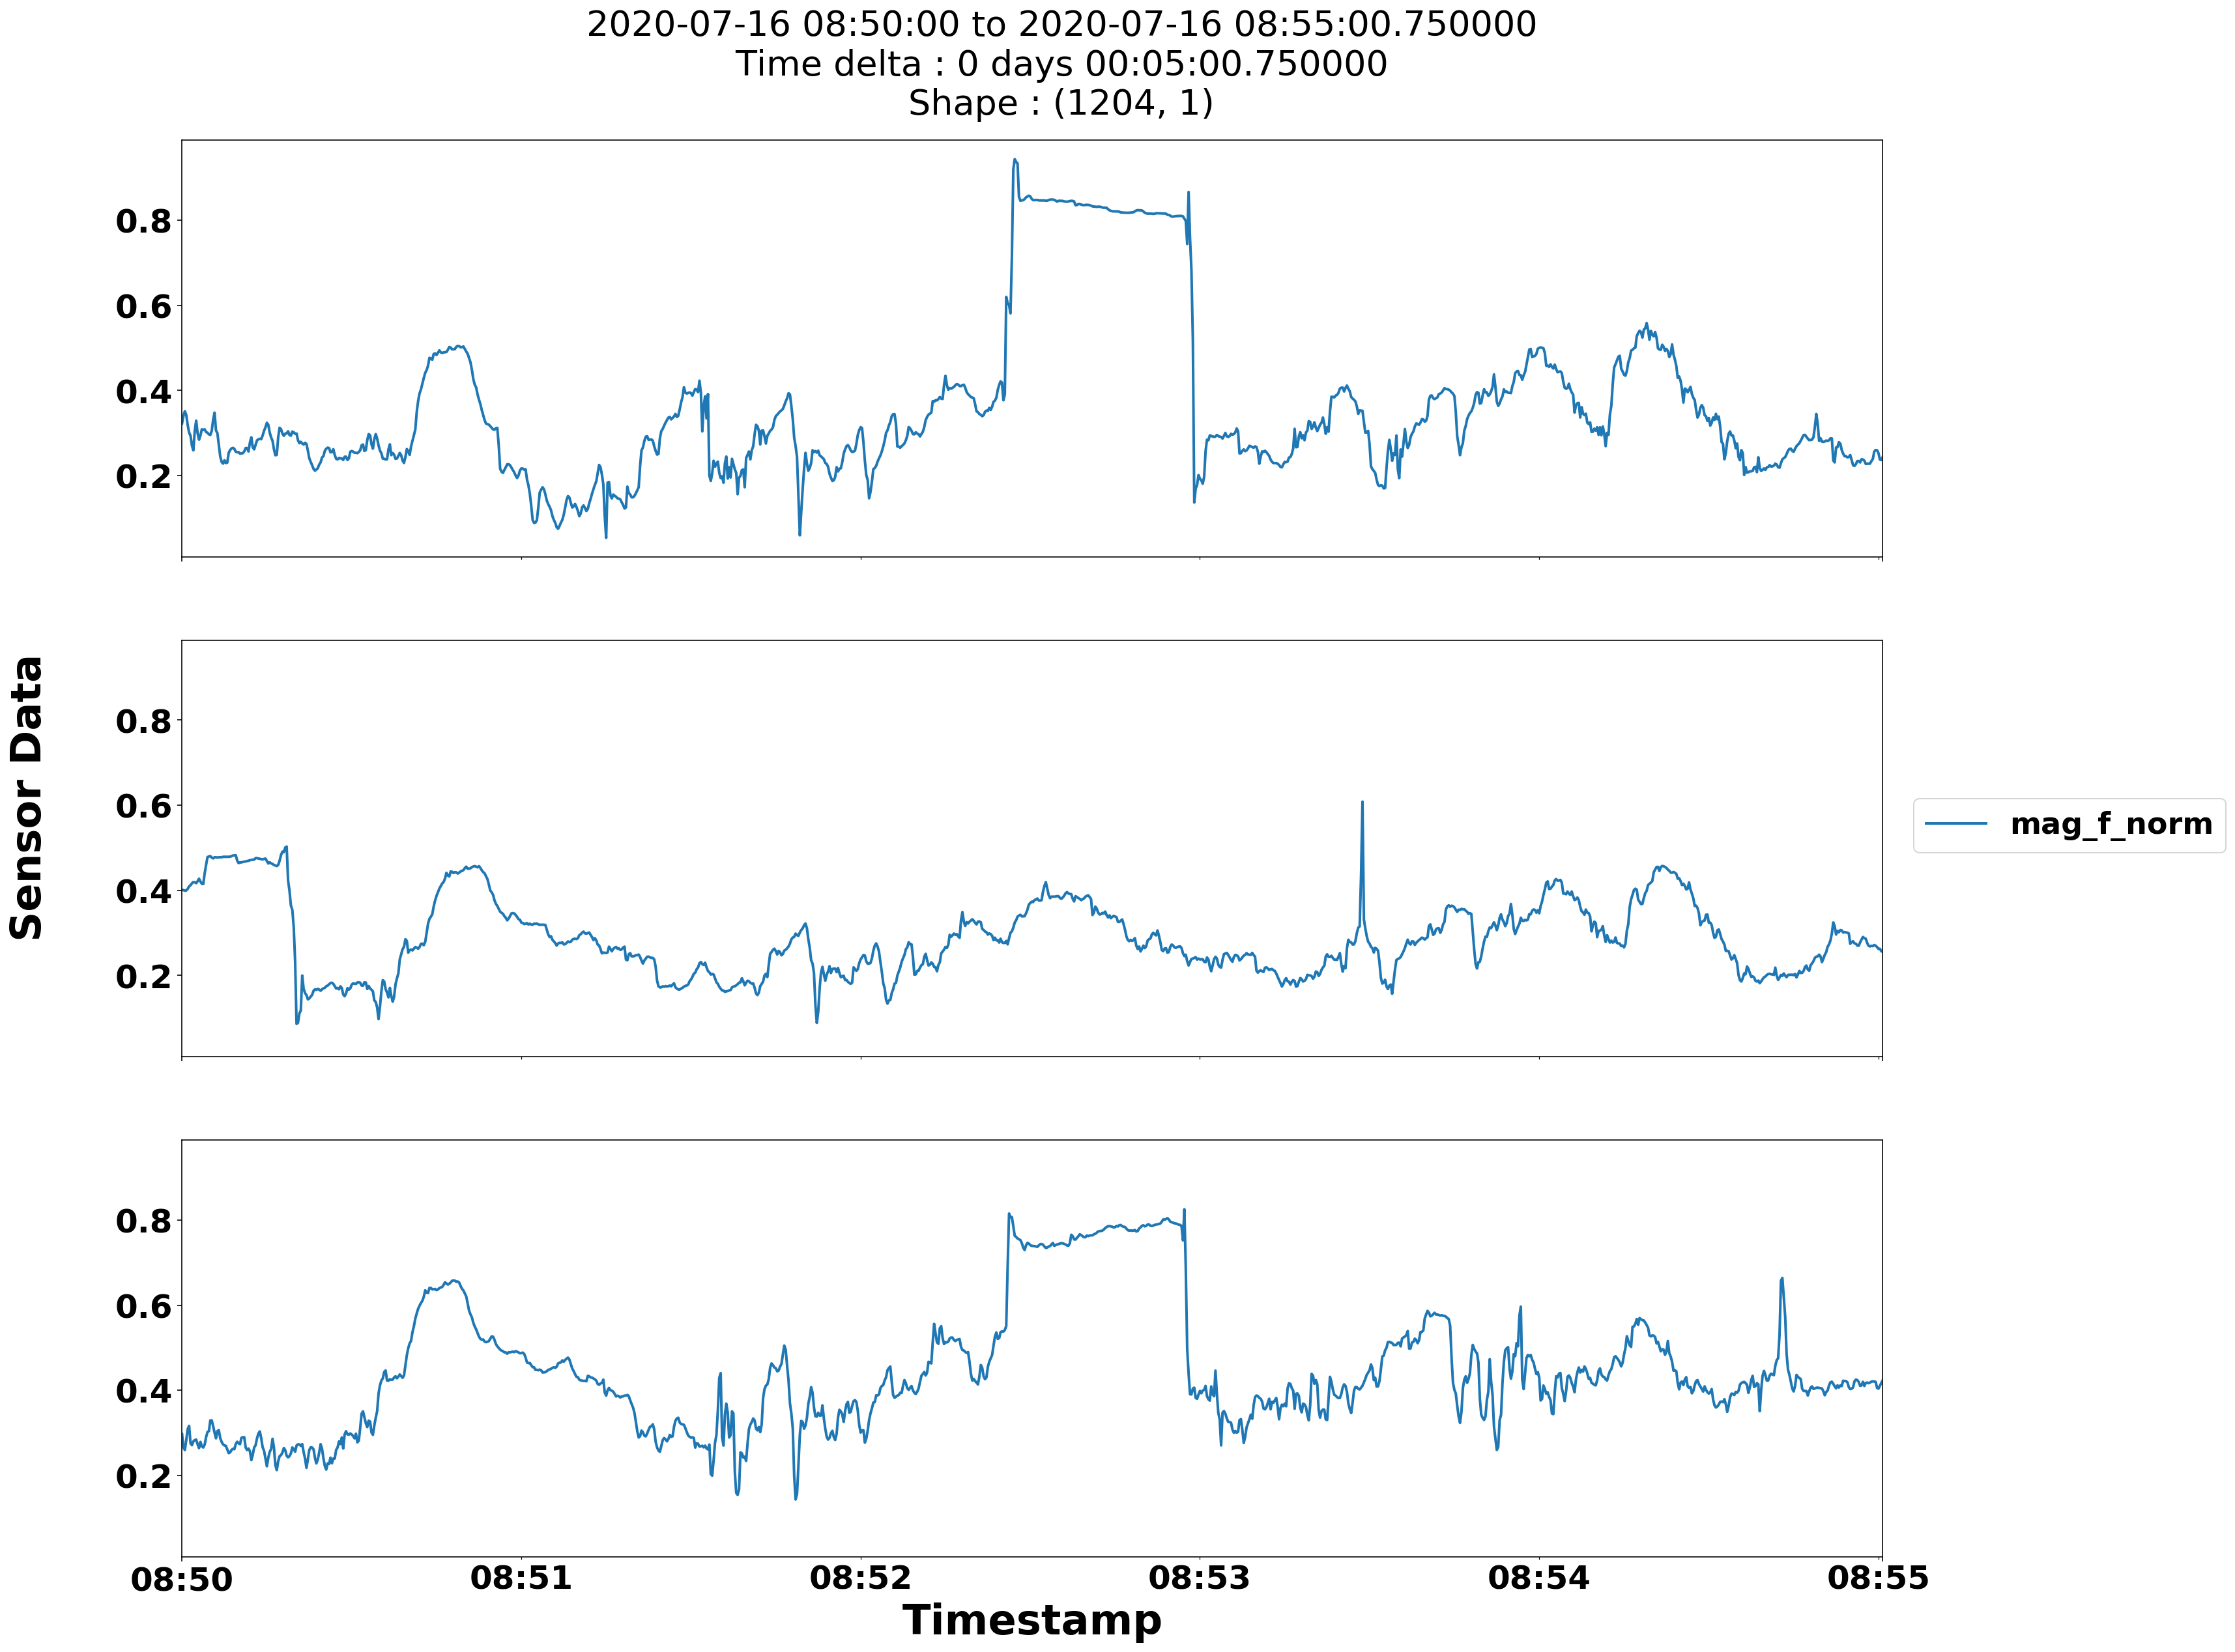

In [13]:
data_display = ['mag_f_norm']
time_from = "2020-07-16 08:50:00"
time_to = "2020-07-16 08:55:00"
data_plotting.plot_data_comp(data, (time_from, time_to), data_display, 
                             'Timestamp', 'Sensor Data', (23, 0.85), 27, (25, 20),
                             dir_name, '(pp)' + file_name + '_st_2tin(ds)', False)

Data 1 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:52:00.750000
Time delta :
 0 days 00:02:00.750000
Shape :
 (484, 1) 

Data 2 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:52:00.750000
Time delta :
 0 days 00:02:00.750000
Shape :
 (484, 1) 

Data 3 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:52:00.750000
Time delta :
 0 days 00:02:00.750000
Shape :
 (484, 1) 



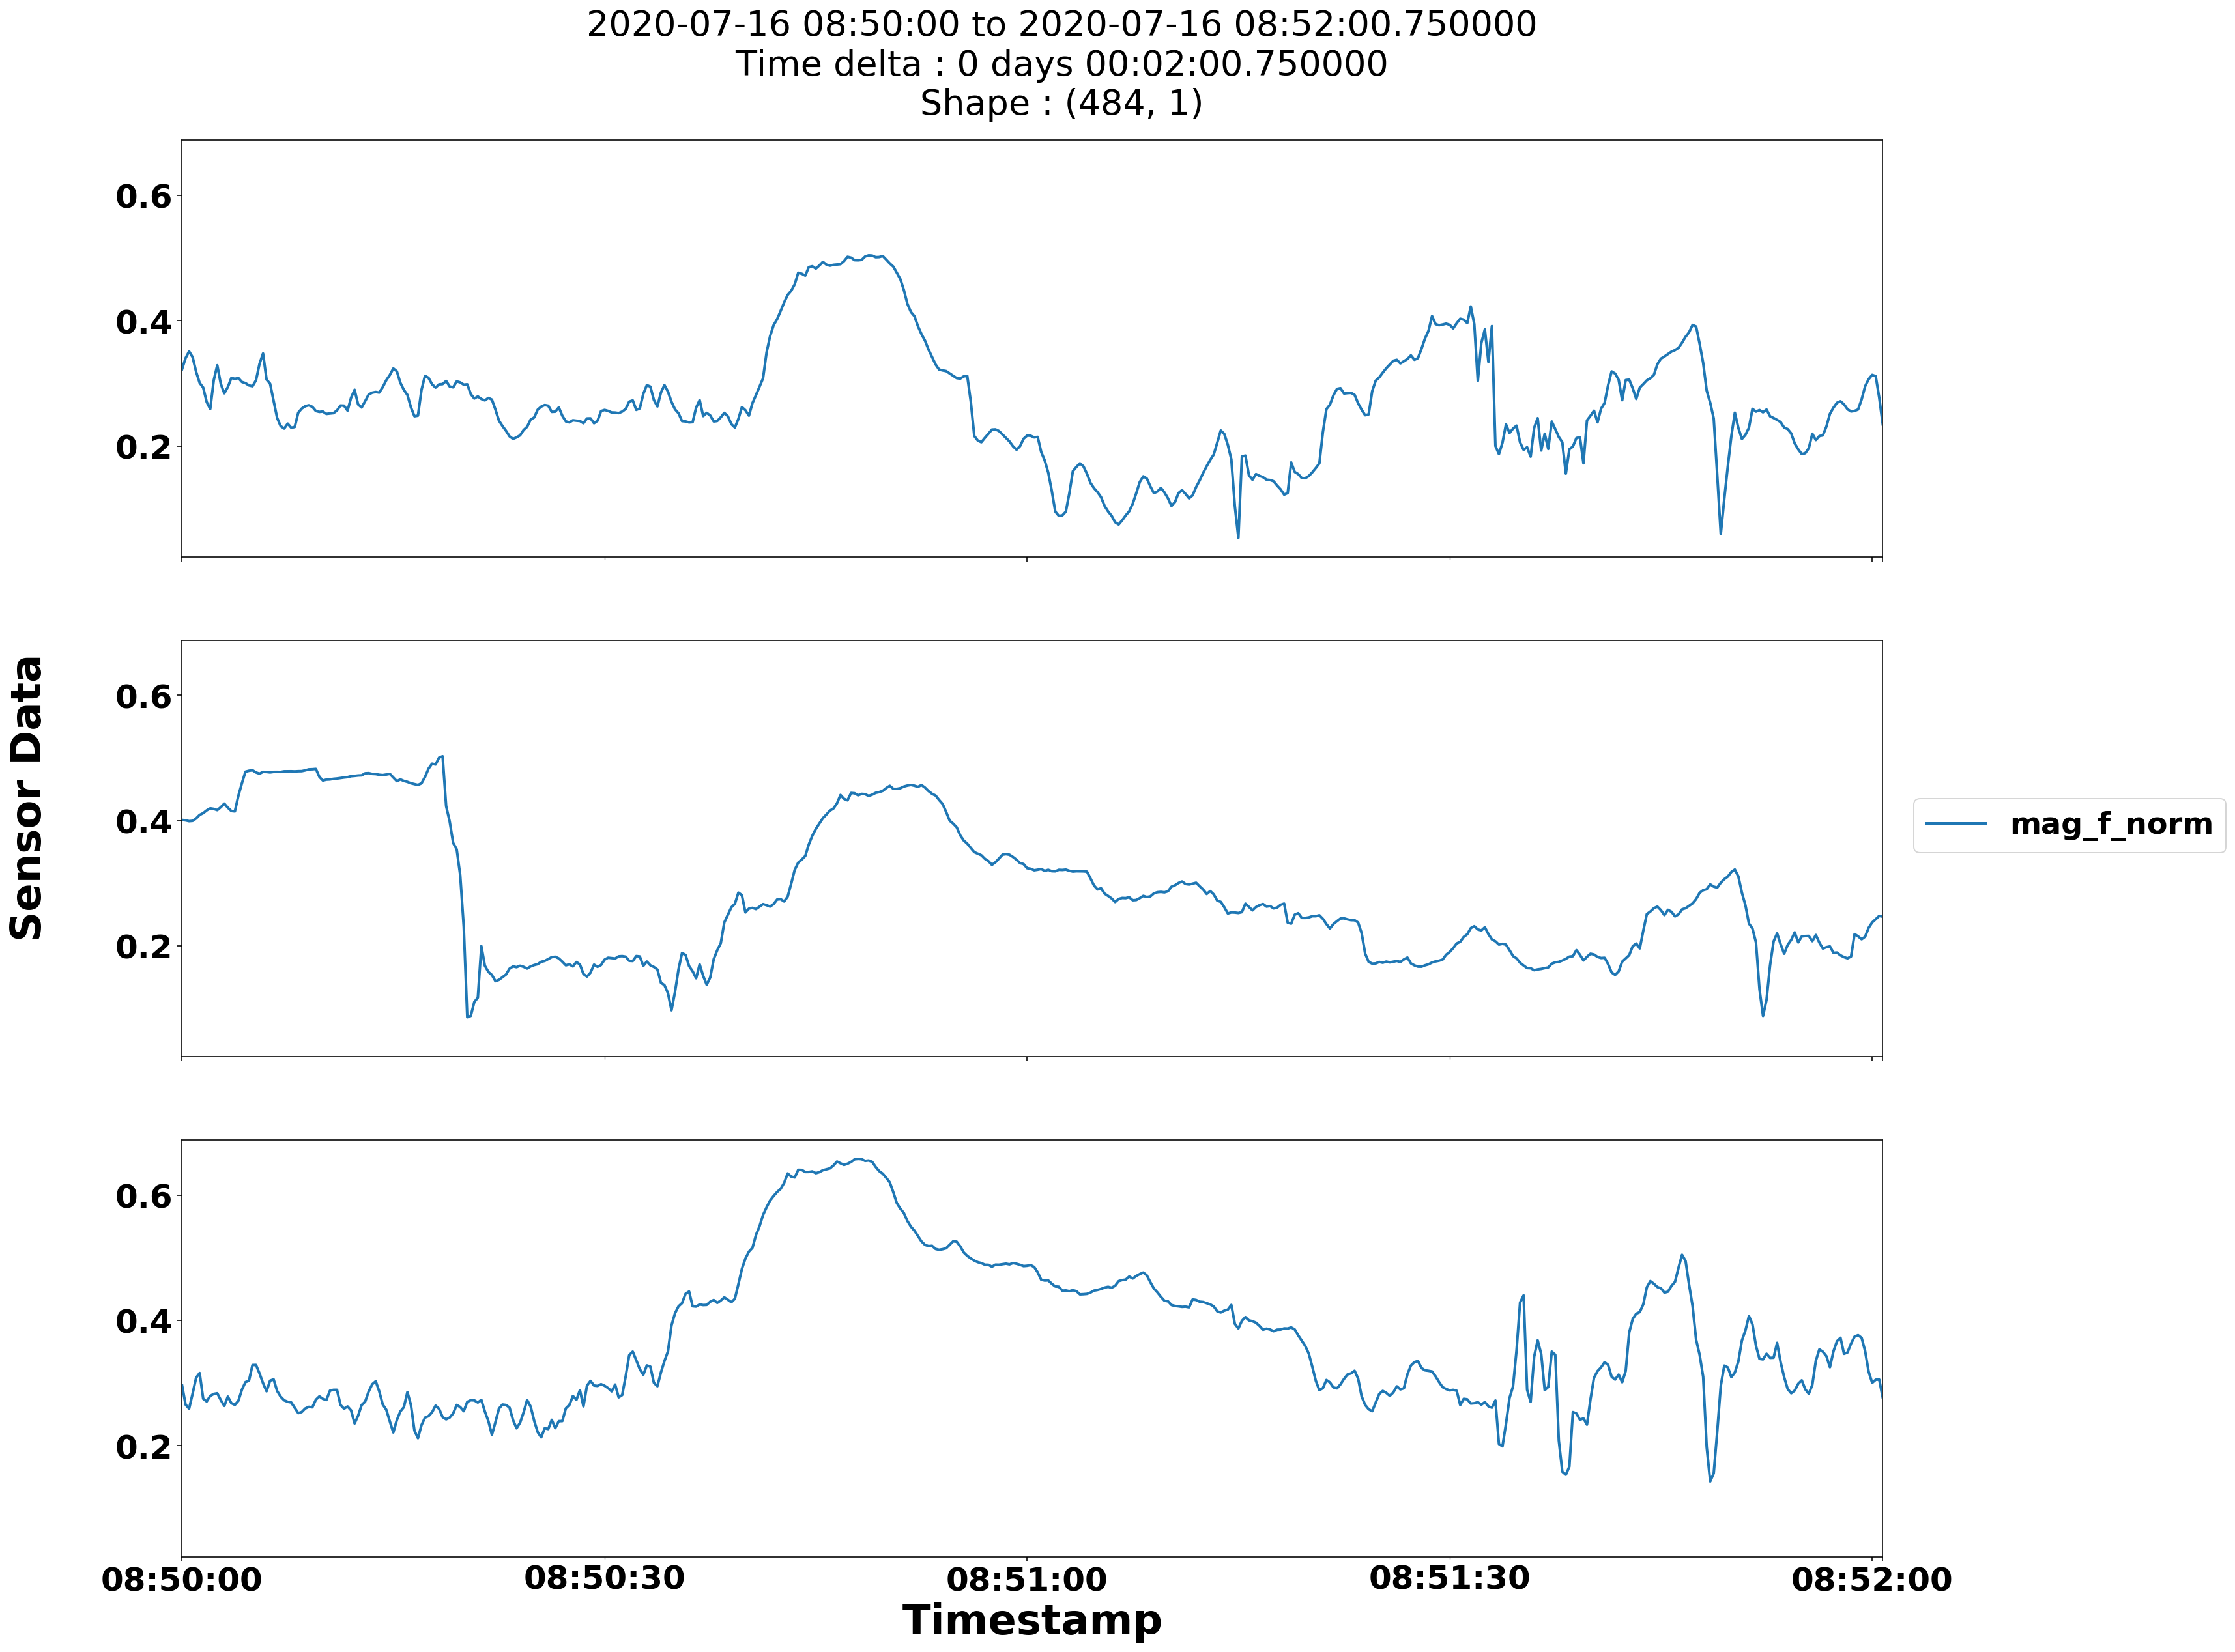

In [14]:
data_display = ['mag_f_norm']
time_from = "2020-07-16 08:50:00"
time_to = "2020-07-16 08:52:00"
data_plotting.plot_data_comp(data, (time_from, time_to), data_display,
                             'Timestamp', 'Sensor Data', (23, 0.85), 27, (25, 20),
                             dir_name, '(pp)' + file_name + '_st_3tin(ds)', False)

### Generating training data

#### Subject 0 - device : E8508BDFF2AE

In [15]:
window = 480
img_fill = False

train_from = '2020-07-16 08:50:00'
train_to = '2020-07-16 08:55:00'
data_train_raw = np.array(data[0][train_from:train_to]['mag_f_norm'])

train_time = '200716_085000-085500'
dir_name = 'E8508BDFF2AE/' + train_time
data_prep.training_img(data_train_raw, window, 1, dir_name, img_fill)

Data shape :  (1204,)

Generating training data...
Number of generated images :  725
Directory : ./generated_data/training/line/E8508BDFF2AE/200716_085000-085500


### Generating test data

#### Subject 1 - device : A8346A9C5F3C

In [16]:
dir_name = 'A8346A9C5F3C/' + train_time
data_prep.test_img(data[1], window, train_from, train_to, dir_name, img_fill)

Same location shape :  (1204,)
Different location shape :  (4581,)

Generating test data...
Number of generated images :  4
Directory : ./generated_data/test/line/same_loc/A8346A9C5F3C/200716_085000-085500
Number of generated images :  18
Directory : ./generated_data/test/line/diff_loc/A8346A9C5F3C/200716_085000-085500


#### Subject 2 - device : F4428F5EB41D

In [17]:
dir_name = 'F4428F5EB41D/' + train_time
data_prep.test_img(data[2], window, train_from, train_to, dir_name, img_fill)

Same location shape :  (1204,)
Different location shape :  (4588,)

Generating test data...
Number of generated images :  4
Directory : ./generated_data/test/line/same_loc/F4428F5EB41D/200716_085000-085500
Number of generated images :  18
Directory : ./generated_data/test/line/diff_loc/F4428F5EB41D/200716_085000-085500


## <ins>Training and testing</ins>

In [18]:
from train import Train

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



### Loading train and test images

In [19]:
img_type = 'line'

# Training images
print('Training data')
train_time = '200716_085000-085500'
train_directory = 'generated_data/training/' + img_type + '/E8508BDFF2AE/' + train_time
data_train = data_prep.load_images(train_directory)

# Same location test images
print('\nSame location test data')
test_directory = 'generated_data/test/' + img_type + '/same_loc/'
data_test_1 = data_prep.load_images(test_directory + 'A8346A9C5F3C/' + train_time)
data_test_2 = data_prep.load_images(test_directory + 'F4428F5EB41D/' + train_time)

# Different location test images
print('\nDifferent location test data')
test_directory = 'generated_data/test/' + img_type + '/diff_loc/'
data_test_false_1 = data_prep.load_images(test_directory + 'A8346A9C5F3C/' + train_time)
data_test_false_2 = data_prep.load_images(test_directory + 'F4428F5EB41D/' + train_time)

Training data
Directory : generated_data/training/line/E8508BDFF2AE/200716_085000-085500
Shape :  (725, 32, 32, 1)

Same location test data
Directory : generated_data/test/line/same_loc/A8346A9C5F3C/200716_085000-085500
Shape :  (4, 32, 32, 1)
Directory : generated_data/test/line/same_loc/F4428F5EB41D/200716_085000-085500
Shape :  (4, 32, 32, 1)

Different location test data
Directory : generated_data/test/line/diff_loc/A8346A9C5F3C/200716_085000-085500
Shape :  (18, 32, 32, 1)
Directory : generated_data/test/line/diff_loc/F4428F5EB41D/200716_085000-085500
Shape :  (18, 32, 32, 1)


### Training

In [20]:
conv = 16
latent_dim = 8
epochs=50
batch_size=32
parent_dir = 'model2_cae/' + img_type + '/AE_3C_1D/200716-174206_174209_174205'

train = Train(data_train)
autoencoder, encoder, decoder, history = train.model2_cae(parent_dir, 'check_point',
                                                          (32, 32, 1), conv, latent_dim, epochs, batch_size)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 32776     
Total params: 33,000
Trainable params: 32,968
Non-trainable params: 32
______________________________________________________

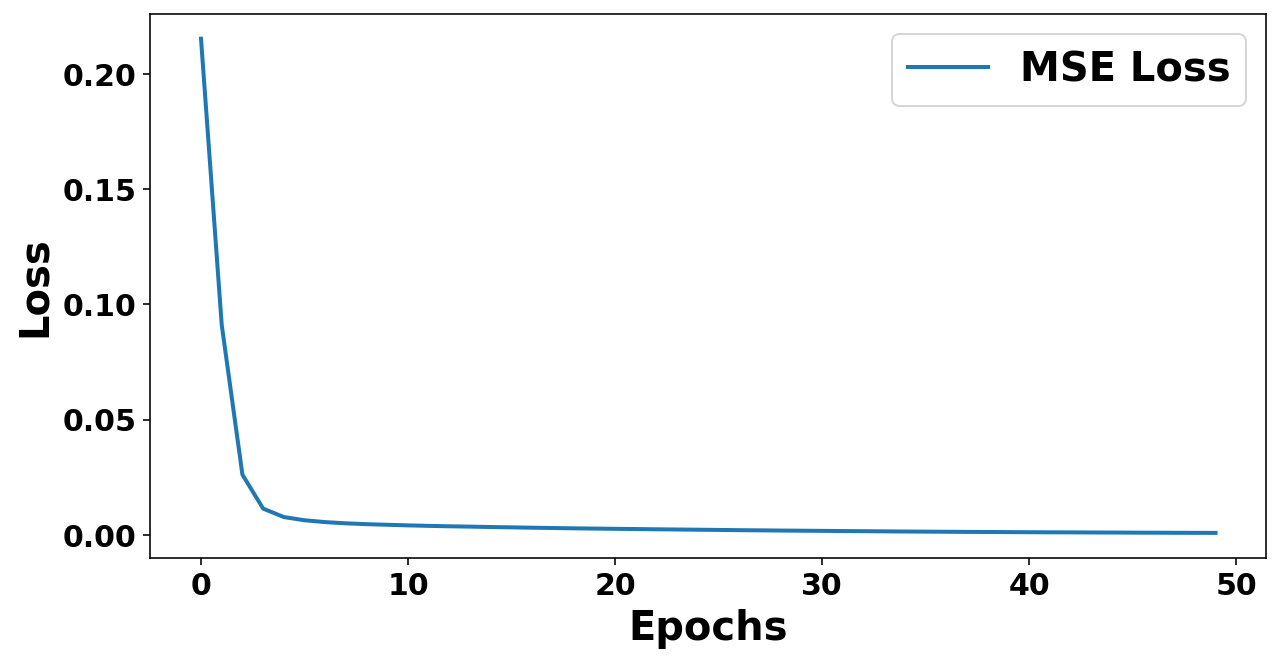

In [21]:
history_dict = history.history
loss_values = history_dict['loss']
hist_plot = pd.DataFrame({'MSE Loss': loss_values})

data_plotting.plot_hist(hist_plot, 'Epochs', 'Loss', 20)

### Testing

In [39]:
directory = 'test'
# reference_mse = train_recon_mse * 5
reference_mse = 0.004
# reference_score = train_recon_score - 0.3
reference_score = 0.7

#### Test Subject 1 - device : A8346A9C5F3C

In [40]:
reconstructed_data_1 = autoencoder.predict(data_test_1)
reconstructed_data_false_1 = autoencoder.predict(data_test_false_1)

results_1, f1_mse_1, f1_ssim_1, conf_matrix_mse_1, conf_matrix_ssim_1 = train.model2_cae_eval(
    reference_mse, reference_score,
    data_test_1, reconstructed_data_1, data_test_false_1, reconstructed_data_false_1)

In [41]:
pd.set_option('display.max_rows', 50)
results_1

,MSE,MSE_prediction,SSIM,SSIM_prediction,Original
0,0.003609,S,0.680121,D,S
1,0.002770,S,0.774309,S,S
2,0.003292,S,0.725556,S,S
3,0.002997,S,0.750762,S,S
4,0.005295,D,0.660431,D,D
5,0.003979,S,0.693399,D,D
6,0.004923,D,0.668769,D,D
7,0.004534,D,0.711269,S,D
8,0.004519,D,0.680642,D,D
9,0.003796,S,0.689186,D,D


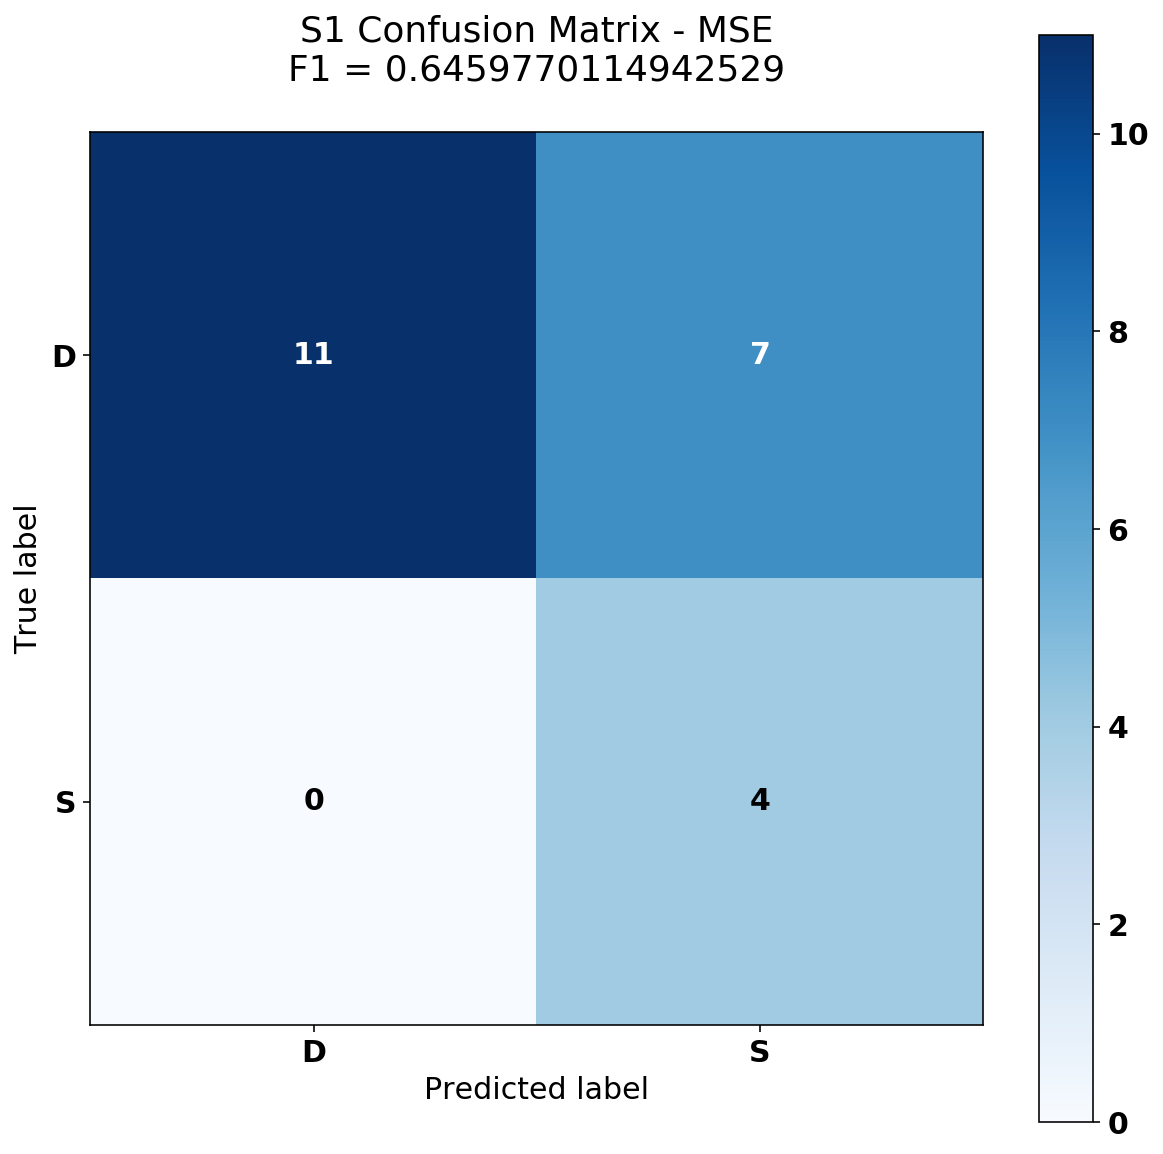

In [42]:
title = 'S1 Confusion Matrix - MSE\nF1 = ' + str(f1_mse_1) + '\n'
data_plotting.plot_conf_matrix(results_1['Original'], results_1['MSE_prediction'],
                               title, parent_dir, directory, 'S1_CM_MSE')

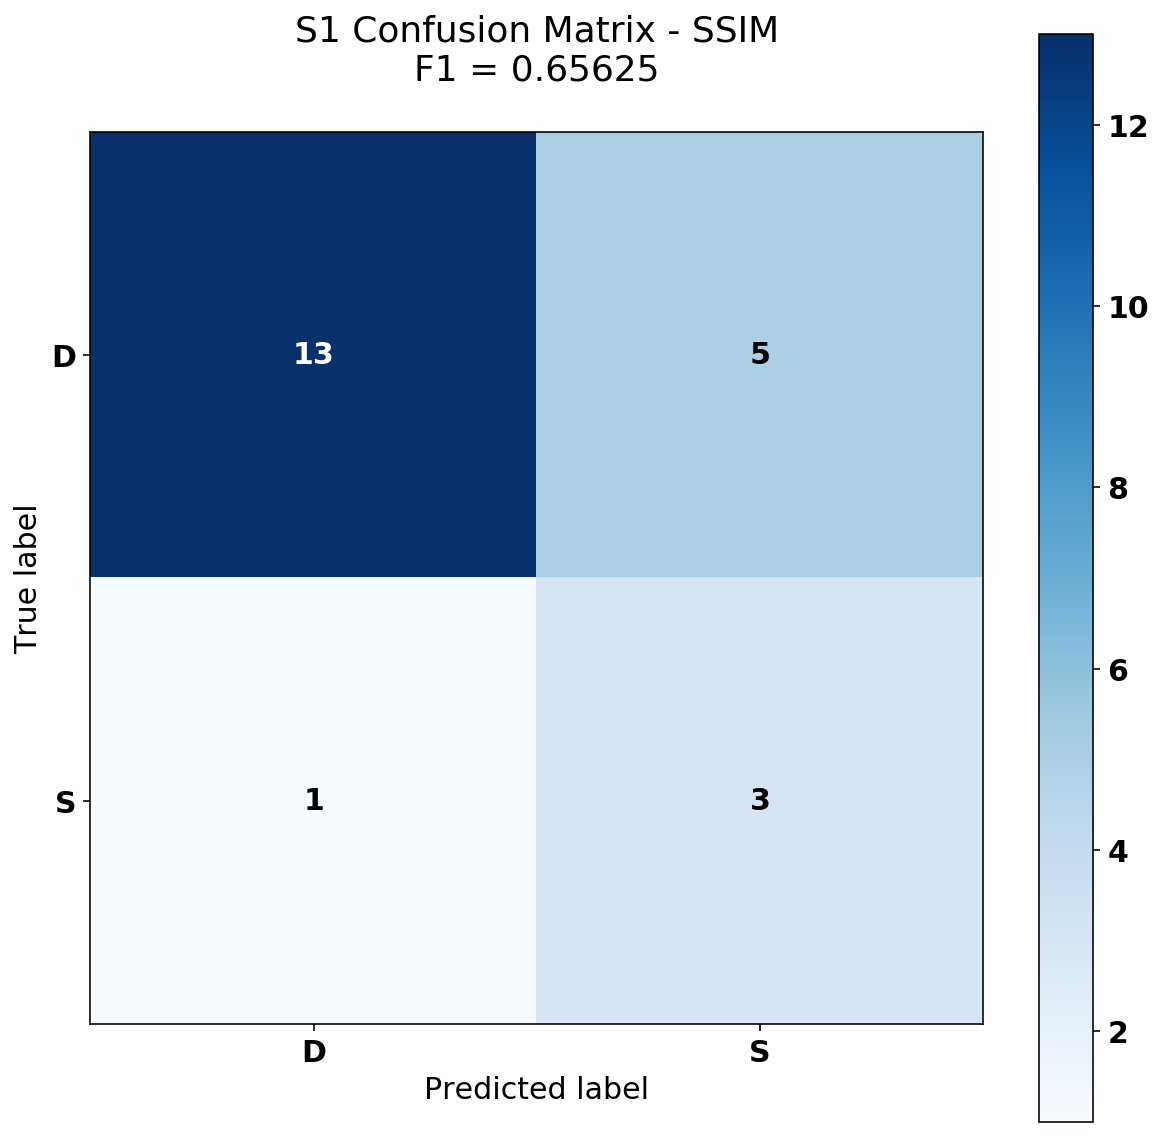

In [43]:
title = 'S1 Confusion Matrix - SSIM\nF1 = ' + str(f1_ssim_1) + '\n'
data_plotting.plot_conf_matrix(results_1['Original'], results_1['SSIM_prediction'],
                               title, parent_dir, directory, 'S1_CM_SSIM')

##### Plotting result

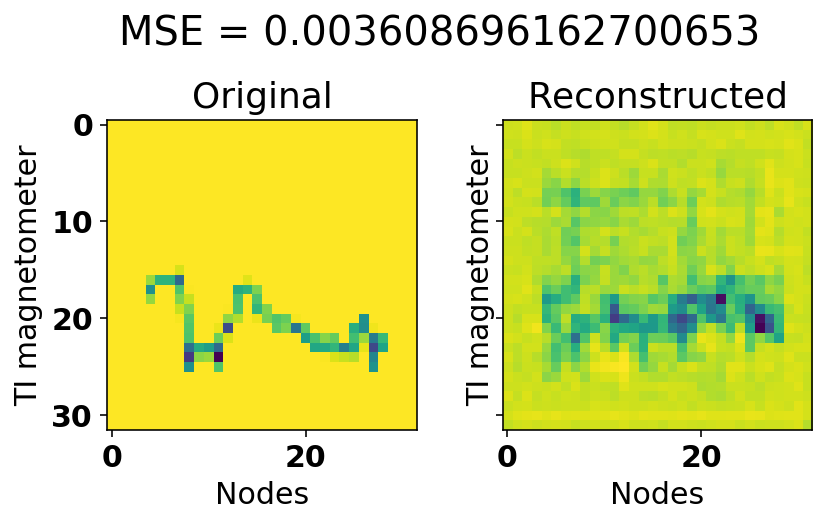

In [44]:
data_plotting.plot_result_cae((data_test_1[0], reconstructed_data_1[0]), 
                          'Nodes', 'TI magnetometer', 15, parent_dir, directory, 'same_location_s1', results_1['MSE'][0])

#### Test Subject 2 - device : F4428F5EB41D

In [45]:
directory = 'test'
# reference_mse = train_recon_mse * 5
reference_mse = 0.004
# reference_score = train_recon_score - 0.3
reference_score = 0.6

In [46]:
reconstructed_data_2 = autoencoder.predict(data_test_2)
reconstructed_data_false_2 = autoencoder.predict(data_test_false_2)

results_2, f1_mse_2, f1_ssim_2, conf_matrix_mse_2, conf_matrix_ssim_2 = train.model2_cae_eval(
    reference_mse, reference_score,
    data_test_2, reconstructed_data_2, data_test_false_2, reconstructed_data_false_2)

In [47]:
pd.set_option('display.max_rows', 50)
results_2

,MSE,MSE_prediction,SSIM,SSIM_prediction,Original
0,0.003720,S,0.726315,S,S
1,0.003756,S,0.677687,S,S
2,0.004569,D,0.671347,S,S
3,0.007302,D,0.600721,S,S
4,0.007758,D,0.601950,S,D
5,0.005693,D,0.518379,D,D
6,0.004932,D,0.578440,D,D
7,0.003211,S,0.690837,S,D
8,0.003309,S,0.712792,S,D
9,0.002714,S,0.735150,S,D


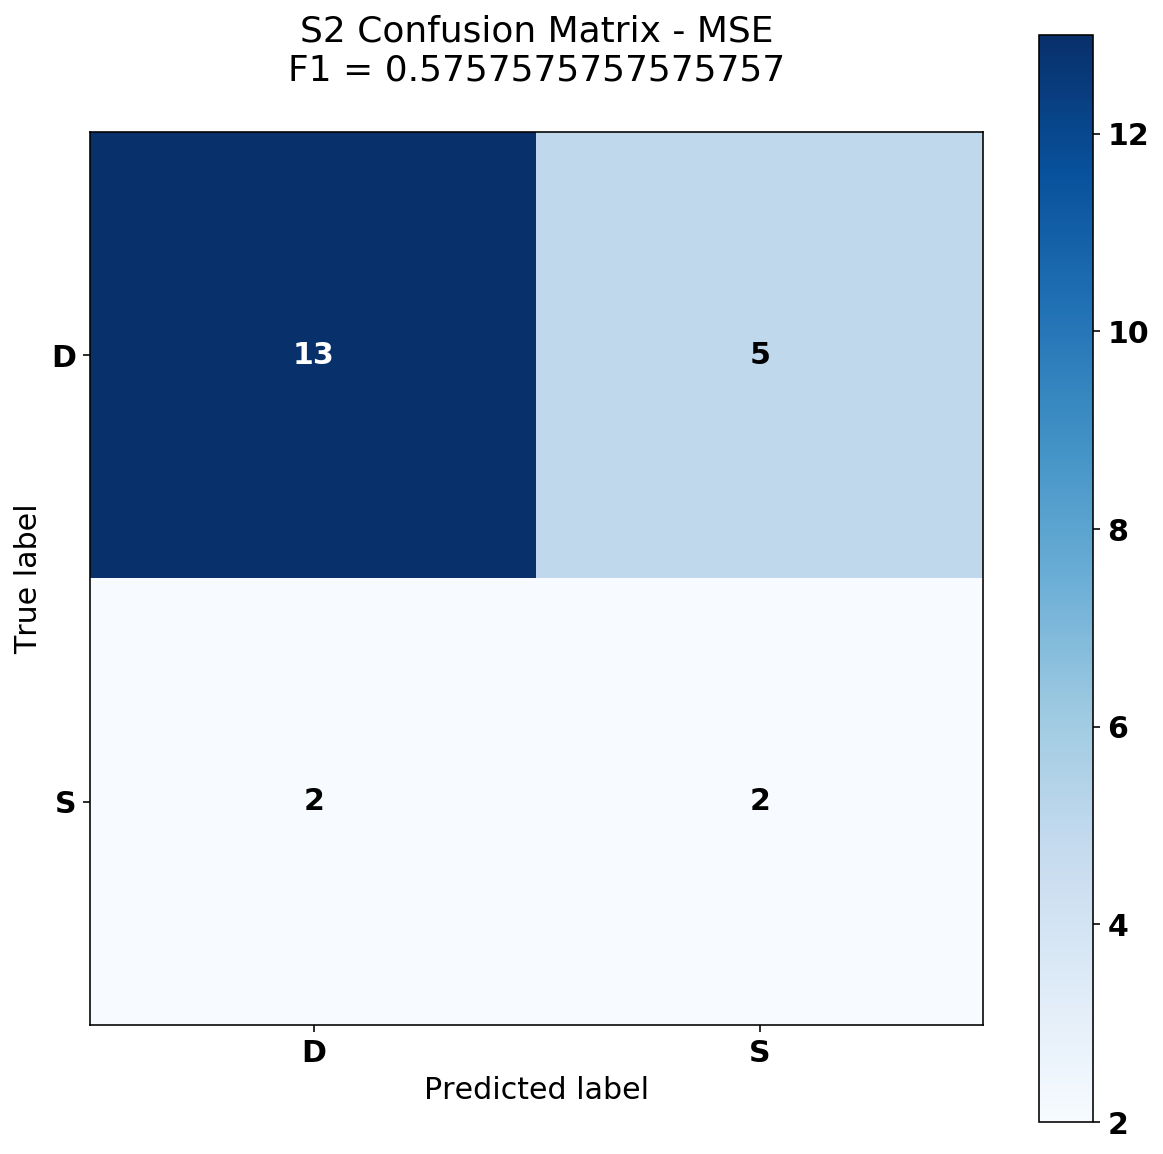

In [48]:
title = 'S2 Confusion Matrix - MSE\nF1 = ' + str(f1_mse_2) + '\n'
data_plotting.plot_conf_matrix(results_2['Original'], results_2['MSE_prediction'],
                               title, parent_dir, directory, 'S2_CM_MSE')

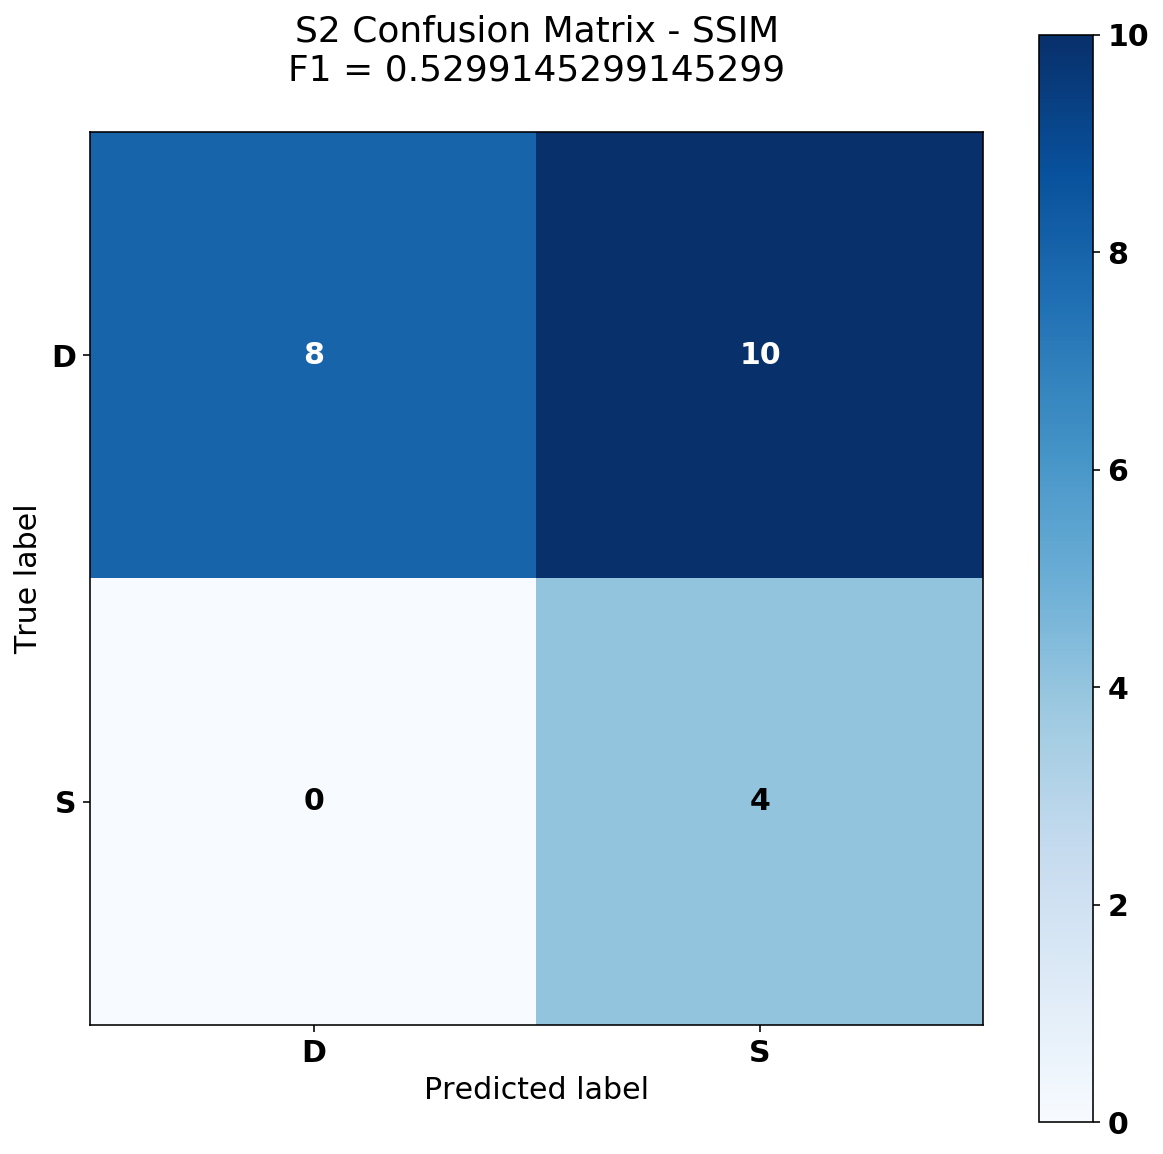

In [49]:
title = 'S2 Confusion Matrix - SSIM\nF1 = ' + str(f1_ssim_2) + '\n'
data_plotting.plot_conf_matrix(results_2['Original'], results_2['SSIM_prediction'],
                               title, parent_dir, directory, 'S2_CM_SSIM')

##### Plotting result

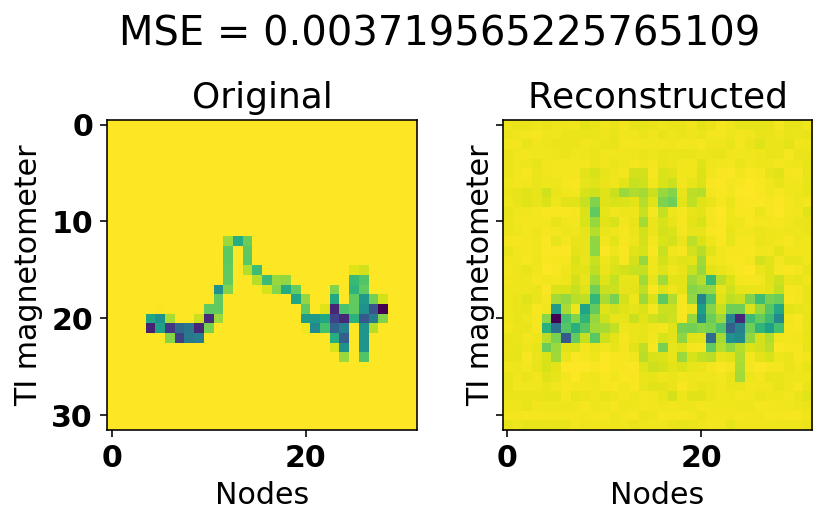

In [50]:
data_plotting.plot_result_cae((data_test_2[0], reconstructed_data_2[0]), 
                          'Nodes', 'TI magnetometer', 15, parent_dir, directory, 'same_location_s2', results_2['MSE'][0])

### Save Model

In [ ]:
description = 'latent_dim=%s \nadam \nmse \nbatch_size=%s \nepochs=%s' % (latent_dim, batch_size, epochs)
train.model_ae_save(autoencoder, encoder, decoder, history, parent_dir, directory, description)